In [122]:
import os
import yaml
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import keras
# from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import layers, models
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import minimize
from pprint import pprint

print("Number of available GPUs: ", len(tf.config.list_physical_devices('GPU')))

# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

Number of available GPUs:  2


In [123]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=1)
    return fits_data[0][0], fits_data[0][1]


def process_image(image):
    # normalize the image to the range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # apply gamma correction
    gamma = find_gamma(image, desired_median=0.2)
    return np.power(image, gamma)


def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2


def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Load the saved model

In [124]:
model = keras.models.load_model('/data/bwedig/lsst-strong-lens-data-challenge/bryce_model.keras')

Take a quick look as the format that the submission CSV needs to have

In [125]:
example_csv = '/grad/bwedig/lsst-strong-lens-data-challenge/submission_format.csv'
example_df = pd.read_csv(example_csv)
print(example_df.head())

            id  preds   ra  dec  zlens  mag_lens_g  mag_lens_r  mag_lens_i  \
0  7.53391E+16      1 -999 -999   -999        -999        -999        -999   
1  7.46439E+16      0 -999 -999   -999        -999        -999        -999   
2  4.42233E+16      1 -999 -999   -999        -999        -999        -999   
3  6.95818E+16      0 -999 -999   -999        -999        -999        -999   
4  6.95997E+16      1 -999 -999   -999        -999        -999        -999   

   mag_lens_z  mag_lens_y  ...  n_l_sers  vel_disp   RA  Dec  mag_object_g  \
0        -999        -999  ...      -999      -999 -999 -999          -999   
1        -999        -999  ...      -999      -999 -999 -999          -999   
2        -999        -999  ...      -999      -999 -999 -999          -999   
3        -999        -999  ...      -999      -999 -999 -999          -999   
4        -999        -999  ...      -999      -999 -999 -999          -999   

   mag_object_r  mag_object_i  mag_object_z  mag_object_y  z_c

Create an empty version of this

In [126]:
df = example_df.iloc[0:0].copy()
print(df)

Empty DataFrame
Columns: [id, preds, ra, dec, zlens, mag_lens_g, mag_lens_r, mag_lens_i, mag_lens_z, mag_lens_y, ell_l, ell_l_PA, Rein, vel disp, sh, sh_PA, srcx, srcy, mag_src_g, mag_src_r, mag_src_i, mag_src_z, mag_src_y, zsrc, ell_s, ell_s_PA, Reff_s, n_s_sers, ell_m, ell_m_PA, Reff_l, n_l_sers, vel_disp, RA, Dec, mag_object_g, mag_object_r, mag_object_i, mag_object_z, mag_object_y, z_central]
Index: []

[0 rows x 41 columns]


Load the `.fits` files, making sure to stack them correctly

In [127]:
data_dir = '/data/bwedig/lsst-strong-lens-data-challenge/test_sim'

fits_files = sorted(glob(os.path.join(data_dir, '*.fits')))
print(f"Found {len(fits_files)} FITS files.")

unique_ids = set([os.path.basename(f).split('.')[0][:-2] for f in fits_files])
print(f"Found {len(unique_ids)} unique IDs.")

Found 200 FITS files.
Found 40 unique IDs.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
ID: GG-LENS_-0.2166_-0.0638, Prediction: 0


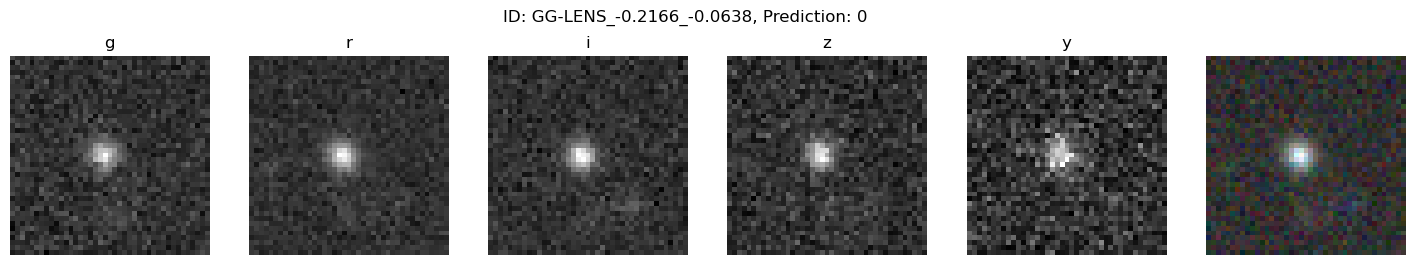

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 37489781684342465, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0054_-0.0269, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0827_0.1399, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
ID: GG-LENS_0.0409_-0.0167, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 69599657268895544, Prediction: 1


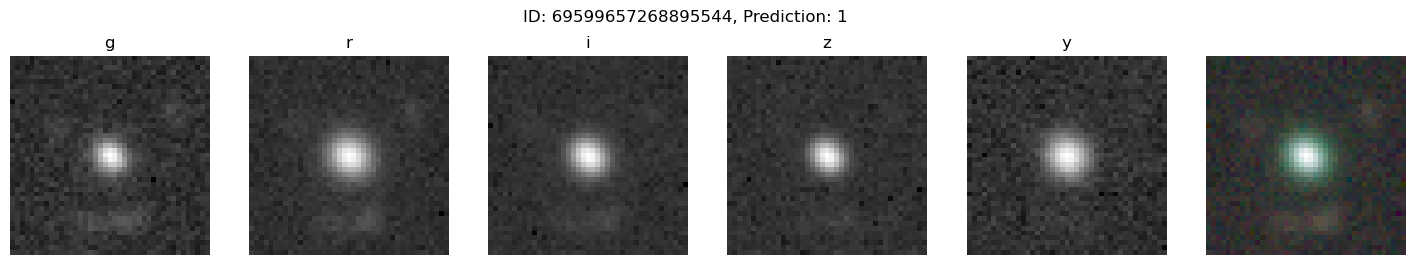

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 75338833087986720, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 70360665344203068, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0199_-0.0174, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_0.1537_-0.0107, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0165_0.0586, Prediction: 1


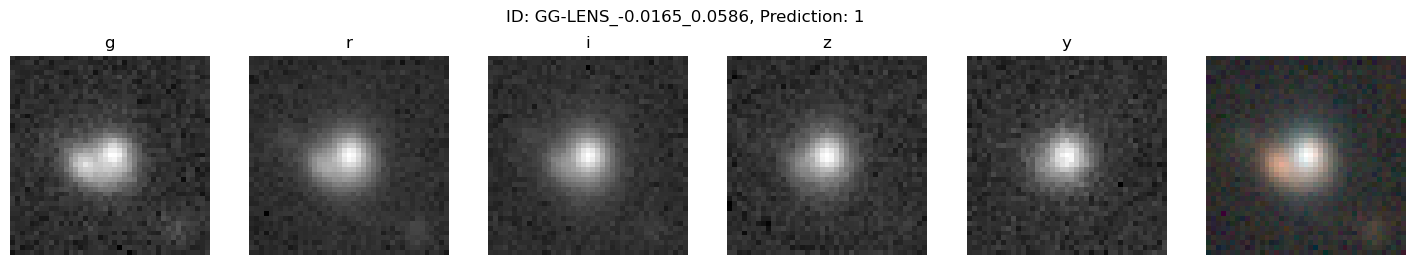

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 44223324036811477, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 69612439091552763, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ID: 69599103218113191, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 69573677011698420, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_0.0371_0.1284, Prediction: 0


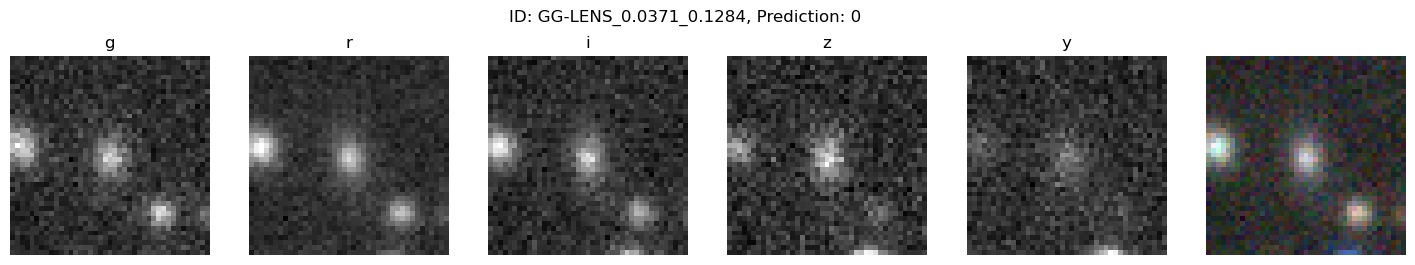

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_0.1268_-0.0595, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0574_0.0986, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ID: 45823676095949100, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ID: 42635367253315079, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ID: 75954409275677042, Prediction: 0


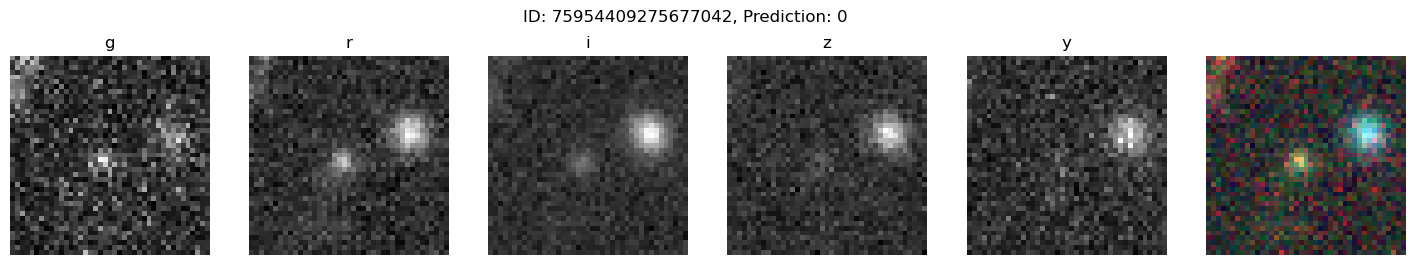

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 69581790204943781, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: 42045891581864408, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
ID: GG-LENS_0.0213_-0.2132, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 41623412828827036, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ID: GG-LENS_0.0328_-0.0317, Prediction: 0


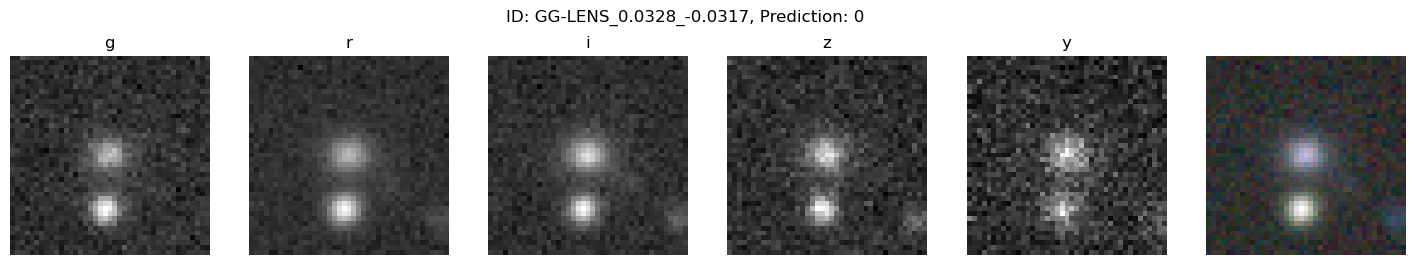

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: GG-LENS_-0.0043_-0.1412, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
ID: 42177407775440432, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: GG-LENS_-0.0663_0.0880, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: GG-LENS_-0.0884_0.0138, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.1426_-0.0392, Prediction: 0


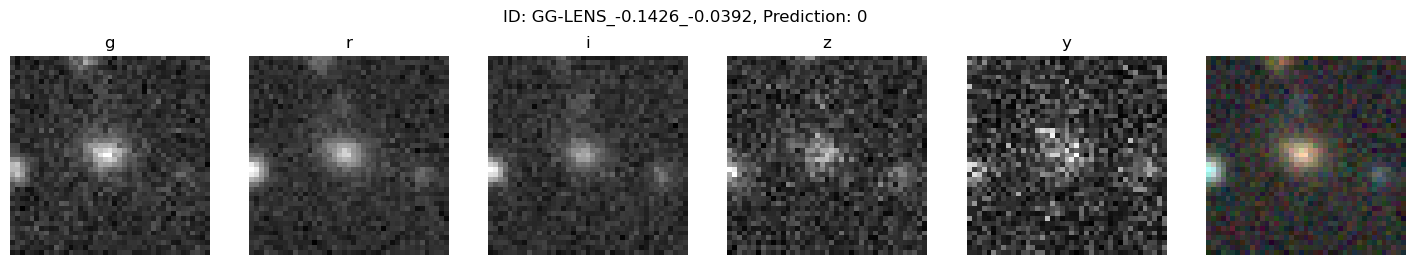

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 75339120850791805, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
ID: 75954684153596822, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.2716_-0.0561, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 74643937444253184, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.2455_0.0251, Prediction: 1


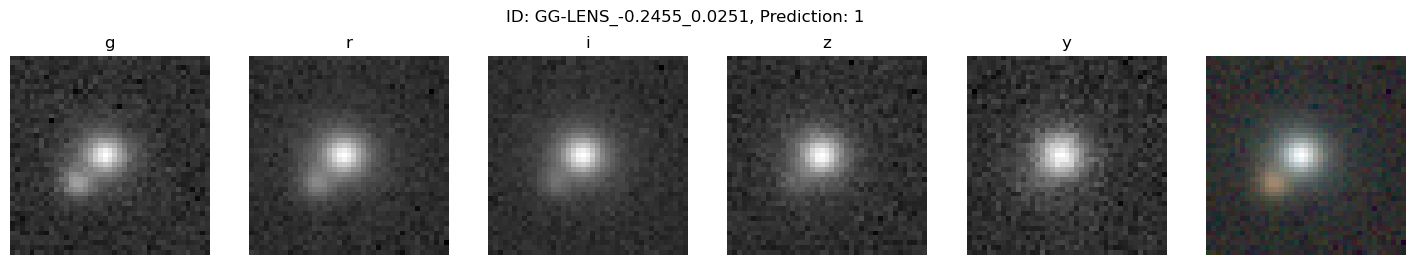

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
ID: GG-LENS_-0.0191_-0.1368, Prediction: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
ID: 37485533961653591, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: 41619693387146252, Prediction: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ID: GG-LENS_-0.0179_-0.0751, Prediction: 0


In [128]:
bands = ['g', 'r', 'i', 'z', 'y']

for i, unique_str in enumerate(unique_ids):
    images = []
    for band in bands:
        file_path = os.path.join(data_dir, f'{unique_str}_{band}.fits')
        id, image = get_image_data(file_path)
        images.append(process_image(image))
    image_stack = np.stack(images, axis=-1)

    # make prediction
    input_stack = np.expand_dims(image_stack, axis=0)  # add batch dimension for prediction
    preds = model.predict(input_stack)
    prediction = int(keras.ops.sigmoid(preds).numpy().flatten()[0] > 0.5)
    print(f"ID: {id}, Prediction: {prediction}")

    # append to dataframe
    new_row = {'id': id, 'preds': prediction}
    df = pd.concat([df, pd.DataFrame([new_row], columns=df.columns)], ignore_index=True)

    # plot subset as sanity check
    if i % 5 == 0:
        f, ax = plt.subplots(1, 6, figsize=(18, 3))
        for j, band in enumerate(bands):
            ax[j].imshow(image_stack[:, :, j], cmap='gray')
            ax[j].set_title(band)
            ax[j].axis('off')
        ax[5].imshow(image_stack[:, :, :3])
        ax[5].axis('off')
        plt.suptitle(f"ID: {id}, Prediction: {prediction}")
        plt.show()

In [129]:
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,GG-LENS_-0.2166_-0.0638,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37489781684342465,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GG-LENS_-0.0054_-0.0269,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GG-LENS_-0.0827_0.1399,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GG-LENS_0.0409_-0.0167,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,69599657268895544,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,75338833087986720,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,70360665344203068,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GG-LENS_-0.0199_-0.0174,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GG-LENS_0.1537_-0.0107,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
df = df.fillna(-999)
df

,id,preds,ra,dec,zlens,mag_lens_g,mag_lens_r,mag_lens_i,mag_lens_z,mag_lens_y,...,n_l_sers,vel_disp,RA,Dec,mag_object_g,mag_object_r,mag_object_i,mag_object_z,mag_object_y,z_central
0,GG-LENS_-0.2166_-0.0638,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,37489781684342465,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,GG-LENS_-0.0054_-0.0269,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,GG-LENS_-0.0827_0.1399,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,GG-LENS_0.0409_-0.0167,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
5,69599657268895544,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
6,75338833087986720,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
7,70360665344203068,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
8,GG-LENS_-0.0199_-0.0174,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
9,GG-LENS_0.1537_-0.0107,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [131]:
df.to_csv('bryce_submission.csv', index=False)